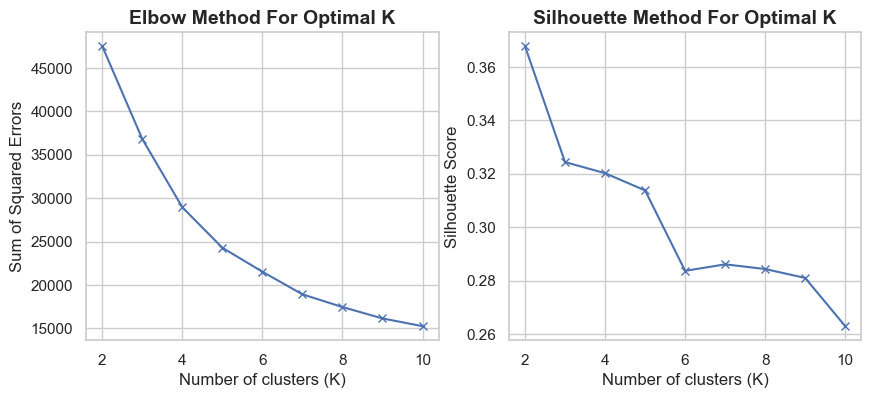

Training Silhouette Score: 0.29
Testing Silhouette Score: 0.29


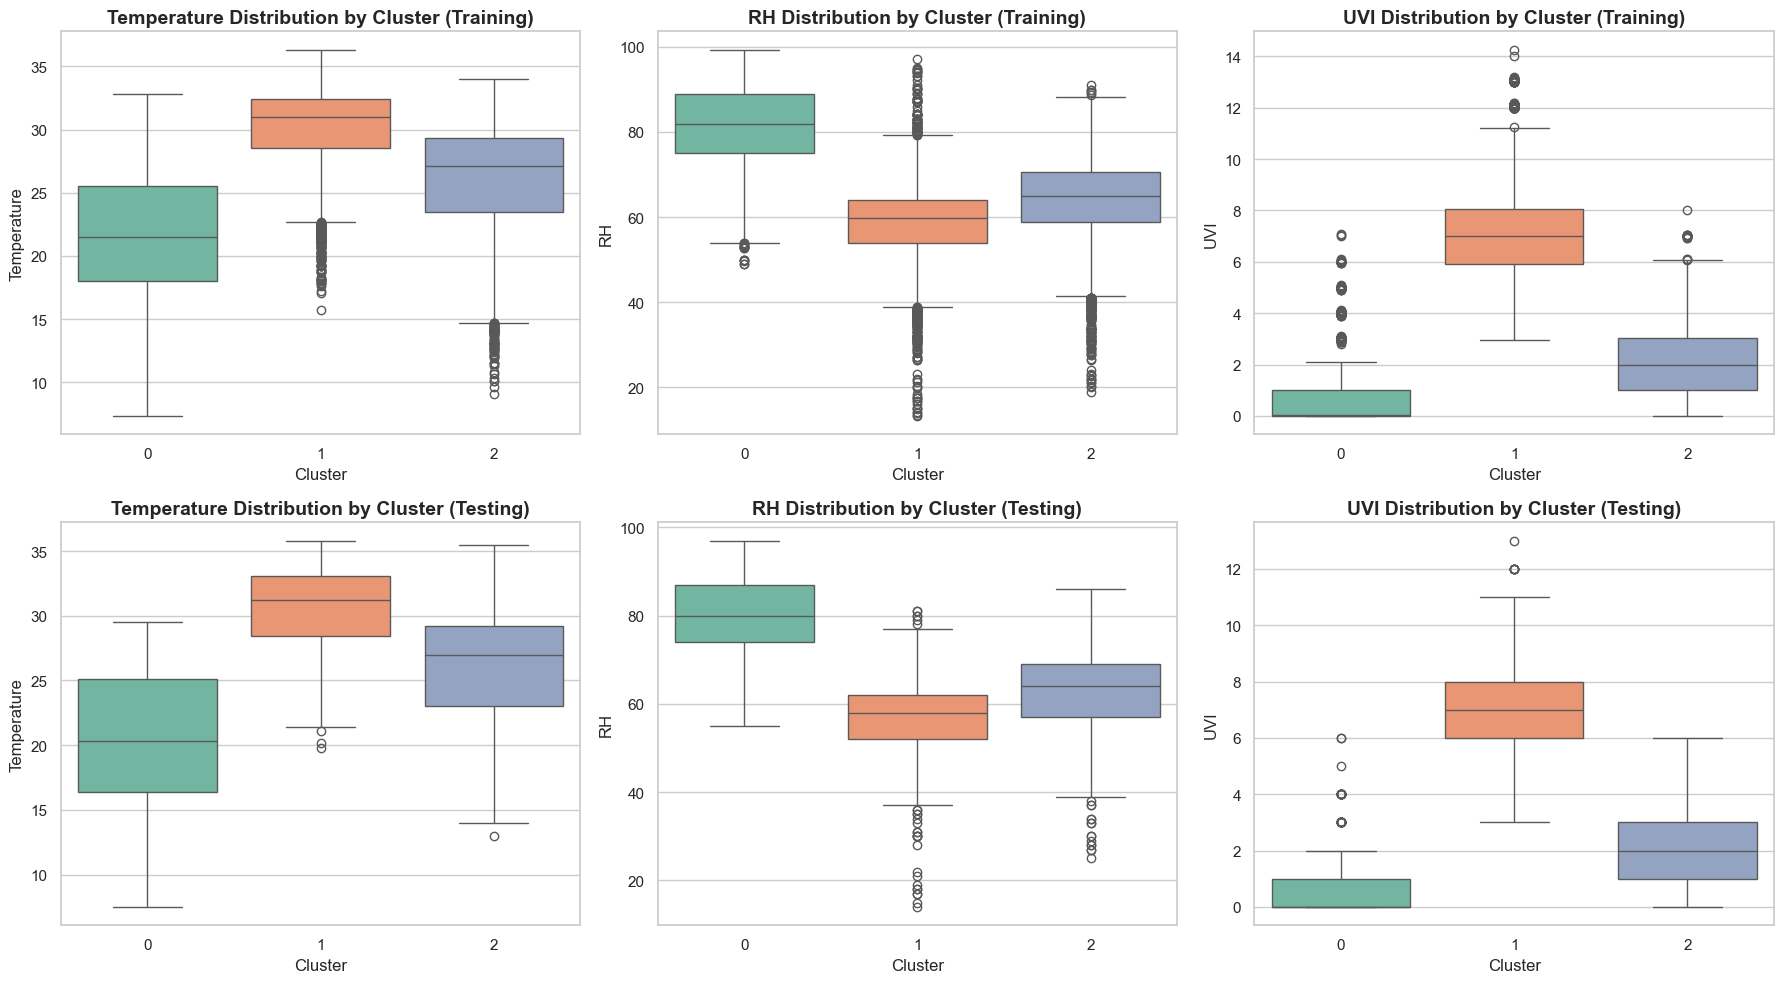

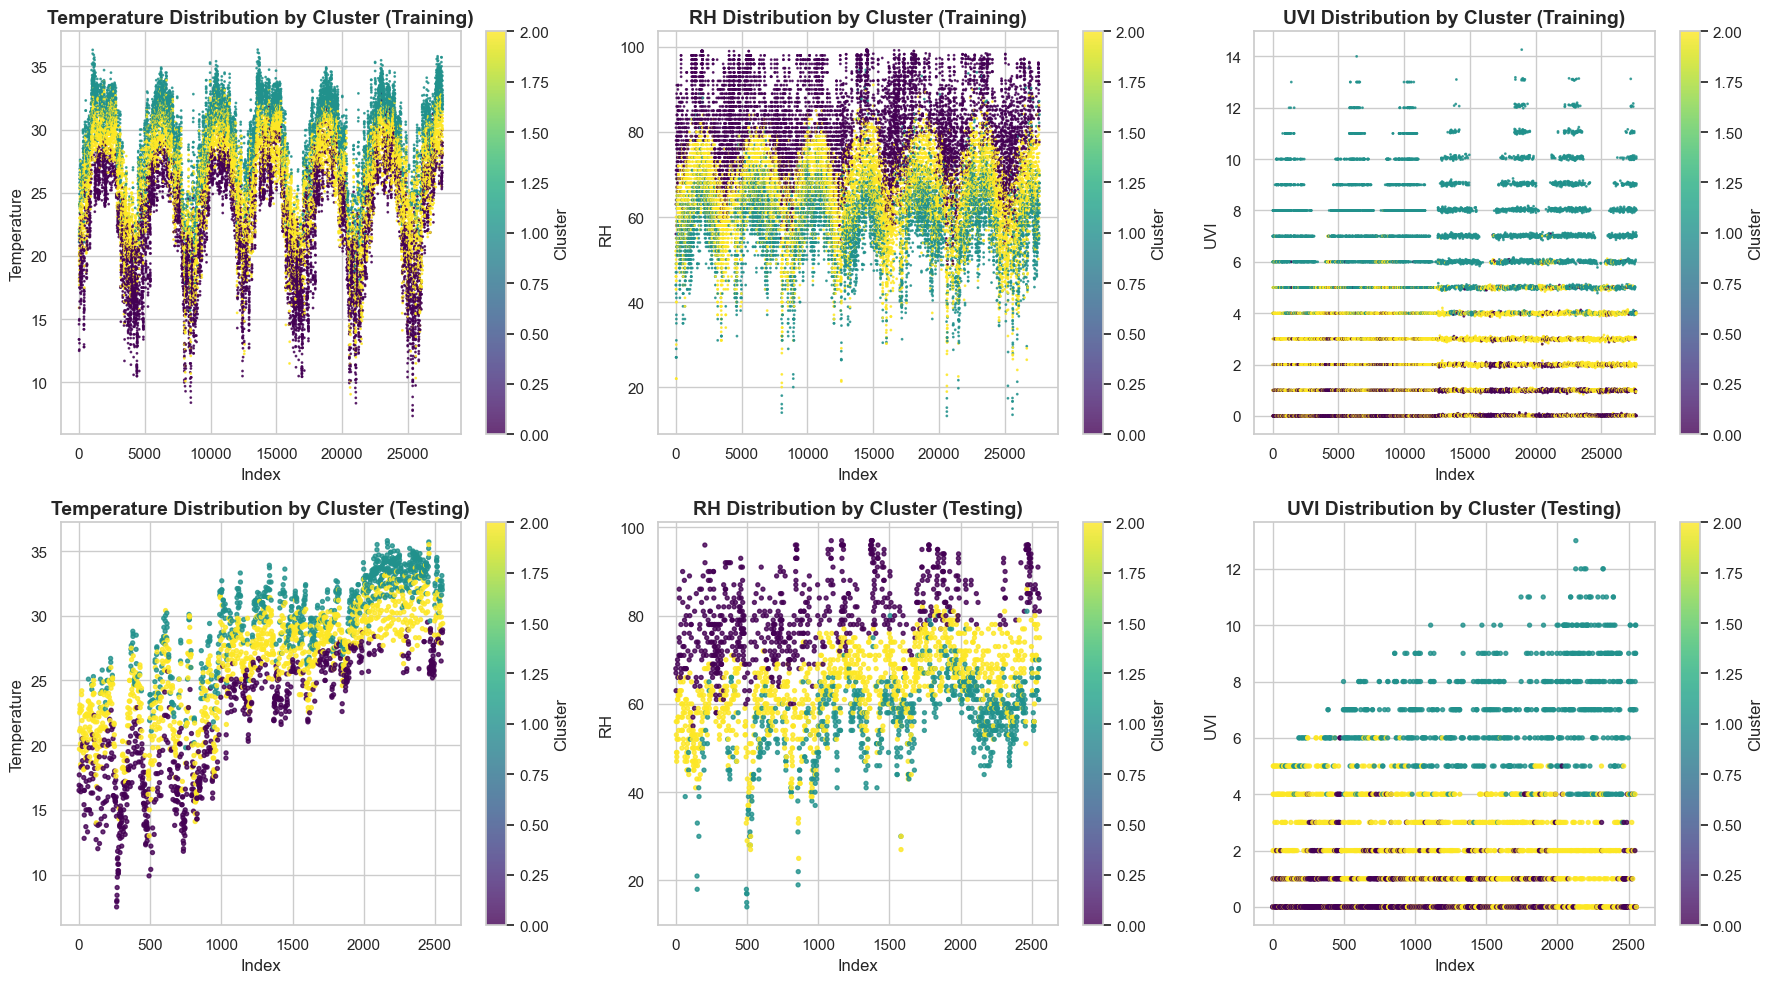

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

train_file_path = 'combined_data.csv'
train_data = pd.read_csv(train_file_path)
train_features = ['Temperature', 'RH', 'UVI']
train_data_points = train_data[train_features].values
scaler = StandardScaler()
train_data_points_scaled = scaler.fit_transform(train_data_points)

test_file_path = '20240101~20240731測試資料.csv'
test_data = pd.read_csv(test_file_path)
test_features = ['Temperature', 'RH', 'UVI']
test_data_points = test_data[test_features].values
test_data_points_scaled = scaler.transform(test_data_points)

class Point:
    def __init__(self, p, dim, id=-1):
        self.coordinates = p
        self.id = id
        self.centroid = None

class Centroid:
    count = 0
    def __init__(self, point):
        self.point = point
        self.id = Centroid.count
        self.pointList = []
        Centroid.count += 1

    def update(self, point):
        self.point = point
        
    def addPoint(self, point):
        self.pointList.append(point)
        
    def removePoint(self, point):
        self.pointList.remove(point)

class Kmeans:
    def __init__(self, k, pointList, kmeansThreshold):
        self.pointList = pointList
        self.k = k
        self.dim = len(pointList[0].coordinates)
        self.kmeansThreshold = kmeansThreshold
        self.centroidList = self.selectSeeds(k)
        self.mainFunction()

    def selectSeeds(self, k):
        seeds = random.sample(self.pointList, k)
        return [Centroid(seed) for seed in seeds]

    def getDistance(self, point1, point2):
        return np.sqrt(sum((point1.coordinates[i] - point2.coordinates[i]) ** 2 for i in range(self.dim)))

    def getCentroid(self, point):
        distances = [self.getDistance(point, centroid.point) for centroid in self.centroidList]
        closestCentroid = np.argmin(distances)
        return closestCentroid, distances[closestCentroid]

    def reCalculateCentroid(self):
        for centroid in self.centroidList:
            if centroid.pointList:
                mean_coords = np.mean([p.coordinates for p in centroid.pointList], axis=0)
                centroid.update(Point(mean_coords, self.dim))

    def assignPointsInit(self):
        for point in self.pointList:
            centroidPos, _ = self.getCentroid(point)
            point.centroid = centroidPos
            self.centroidList[centroidPos].addPoint(point)

    def assignPoints(self):
        for centroid in self.centroidList:
            for point in centroid.pointList[:]:
                newCentroidPos, _ = self.getCentroid(point)
                if point.centroid != newCentroidPos:
                    centroid.removePoint(point)
                    point.centroid = newCentroidPos
                    self.centroidList[newCentroidPos].addPoint(point)

    def calculateError(self):
        return sum(self.getDistance(point, self.centroidList[point.centroid].point) ** 2 for point in self.pointList)

    def mainFunction(self):
        self.assignPointsInit()
        previousError = self.calculateError()
        while True:
            self.reCalculateCentroid()
            self.assignPoints()
            currentError = self.calculateError()
            if abs(previousError - currentError) < self.kmeansThreshold:
                break
            previousError = currentError

def evaluate_k_values(data_points_scaled, max_k=10):
    sse = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = Kmeans(k, [Point(p, len(train_features), id=i) for i, p in enumerate(data_points_scaled)], kmeansThreshold=0.003)
        labels = [point.centroid for point in kmeans.pointList]
        
        sse.append(kmeans.calculateError())
        
        silhouette_avg = silhouette_score(data_points_scaled, labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(K_range, sse, 'bx-')
    plt.xlabel('Number of clusters (K)', fontsize=12)
    plt.ylabel('Sum of Squared Errors', fontsize=12)
    plt.title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
    
    plt.subplot(1, 2, 2)
    plt.plot(K_range, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters (K)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Method For Optimal K', fontsize=14, fontweight='bold')
    plt.show()

evaluate_k_values(train_data_points_scaled, max_k=10)

train_pointList = [Point(p, len(train_features), id=i) for i, p in enumerate(train_data_points_scaled)]

k = 3
kmeansThreshold = 0.001
kmeans = Kmeans(k, train_pointList, kmeansThreshold)
train_data['Cluster'] = [point.centroid for point in train_pointList]

test_pointList = [Point(p, len(test_features), id=i) for i, p in enumerate(test_data_points_scaled)]
for point in test_pointList:
    centroidPos, _ = kmeans.getCentroid(point)
    point.centroid = centroidPos
test_data['Cluster'] = [point.centroid for point in test_pointList]

silhouette_avg_train = silhouette_score(train_data_points_scaled, train_data['Cluster'])
silhouette_avg_test = silhouette_score(test_data_points_scaled, test_data['Cluster'])
print(f'Training Silhouette Score: {silhouette_avg_train:.2f}')
print(f'Testing Silhouette Score: {silhouette_avg_test:.2f}')

def plot_cluster_feature_distribution(train_data, test_data, features):
    plt.figure(figsize=(18, 10))
    
    sns.set(style="whitegrid")
    sns.set_palette("Set2")

    for i, feature in enumerate(features):
        plt.subplot(2, len(features), i + 1)
        sns.boxplot(x='Cluster', y=feature, data=train_data, hue='Cluster', palette="Set2", legend=False)
        plt.title(f'{feature} Distribution by Cluster (Training)', fontsize=14, fontweight='bold')
        plt.xlabel('Cluster', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        
        plt.subplot(2, len(features), i + len(features) + 1)
        sns.boxplot(x='Cluster', y=feature, data=test_data, hue='Cluster', palette="Set2", legend=False)
        plt.title(f'{feature} Distribution by Cluster (Testing)', fontsize=14, fontweight='bold')
        plt.xlabel('Cluster', fontsize=12)
        plt.ylabel(feature, fontsize=12)
    
    plt.tight_layout()
    plt.show()

plot_cluster_feature_distribution(train_data, test_data, ['Temperature', 'RH', 'UVI'])

def plot_feature_distribution(train_data, test_data, features):
    plt.figure(figsize=(18, 10))
    
    cmap = plt.get_cmap('viridis')

    for i, feature in enumerate(features):
        plt.subplot(2, 3, i + 1)
        plt.scatter(train_data.index, train_data[feature], c=train_data['Cluster'], cmap=cmap, alpha=0.8, s=1)
        plt.xlabel('Index', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.title(f'{feature} Distribution by Cluster (Training)', fontsize=14, fontweight='bold')
        plt.grid(True)
        plt.colorbar(label='Cluster')
        
        plt.subplot(2, 3, i + 4)
        plt.scatter(test_data.index, test_data[feature], c=test_data['Cluster'], cmap=cmap, alpha=0.8, s=8)
        plt.xlabel('Index', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.title(f'{feature} Distribution by Cluster (Testing)', fontsize=14, fontweight='bold')
        plt.grid(True)
        plt.colorbar(label='Cluster')
    
    plt.tight_layout()
    plt.show()

plot_feature_distribution(train_data, test_data, ['Temperature', 'RH', 'UVI'])

訓練集中各個類別數量:
Sunny            11250
Partly Cloudy     8095
Overcast          8315
dtype: int64


測試集中各個類別數量:
Sunny            1083
Partly Cloudy     723
Overcast          750
dtype: int64




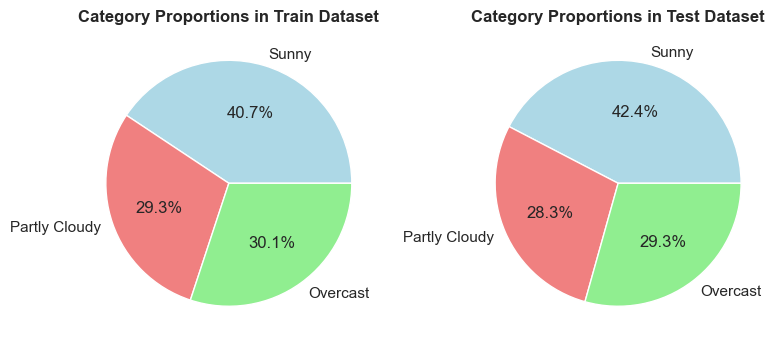

訓練集聚類結果已保存到 train_dataset.csv
測試集聚類結果已保存到 test_dataset.csv


In [4]:
train_cluster_encoded = pd.get_dummies(train_data['Cluster'], prefix='Cluster').astype(int)
test_cluster_encoded = pd.get_dummies(test_data['Cluster'], prefix='Cluster').astype(int)

cluster_mapping = {
    'Cluster_0': 'Partly Cloudy',
    'Cluster_1': 'Overcast',
    'Cluster_2': 'Sunny'
}

train_cluster_encoded.rename(columns=cluster_mapping, inplace=True)
test_cluster_encoded.rename(columns=cluster_mapping, inplace=True)

train_data_encoded = pd.concat([train_data.drop(columns=['Cluster']), train_cluster_encoded], axis=1)
test_data_encoded = pd.concat([test_data.drop(columns=['Cluster']), test_cluster_encoded], axis=1)

train_encoded_counts = train_data_encoded[['Sunny', 'Partly Cloudy', 'Overcast']].sum()
print("訓練集中各個類別數量:")
print(train_encoded_counts)
print("\n")

test_encoded_counts = test_data_encoded[['Sunny', 'Partly Cloudy', 'Overcast']].sum()
print("測試集中各個類別數量:")
print(test_encoded_counts)
print("\n")

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.pie(train_encoded_counts, labels=train_encoded_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen'])
plt.title('Category Proportions in Train Dataset', fontsize=12, fontweight='bold')
plt.subplot(1, 2, 2)
plt.pie(test_encoded_counts, labels=test_encoded_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen'])
plt.title('Category Proportions in Test Dataset', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

train_data_encoded = train_data_encoded.drop(columns=['Overcast'])
test_data_encoded = test_data_encoded.drop(columns=['Overcast'])

train_output_file_path = 'train_dataset.csv'
test_output_file_path = 'test_dataset.csv'
train_data_encoded.to_csv(train_output_file_path, index=False)
test_data_encoded.to_csv(test_output_file_path, index=False)
print(f'訓練集聚類結果已保存到 {train_output_file_path}')
print(f'測試集聚類結果已保存到 {test_output_file_path}')
